# Models Development
by: Kaike W. Reis

## Steps
- Importing Data
- Train Test Split 
- Oversampling
- Transforming data
- Auxiliar functions
- Hyper parameters optimization
- Dummy Classifiers
- Backtest creation
- Exporting all results/models from here


## Modules

In [1]:
# Standard modules
from time import sleep
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

# Graphical modules
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Workaround for skopt with sklearn==0.23.1
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray

# Development
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as XGBoost
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Export
import joblib

# Importing Data

In [2]:
# Dataset
df = pd.read_csv('results_EDA/paper_dataset.csv')

# Train Test Split

In [3]:
# Define X and Y
features = ['Patient age quantile','Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
            'Monocytes', 'Platelets', 'RDW']
# Get X and Y
x = df[features]
y = df['COVID-19 Exam result']

In [4]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 101, stratify=y)

In [5]:
# % of target class in train set
pd.Series(y_train).value_counts()/len(y_train)

0    0.864173
1    0.135827
Name: COVID-19 Exam result, dtype: float64

In [6]:
# target class in train set
pd.Series(y_train).value_counts()

0    439
1     69
Name: COVID-19 Exam result, dtype: int64

In [7]:
# % of target class in test set
y_test.value_counts()/len(y_test)

0    0.866667
1    0.133333
Name: COVID-19 Exam result, dtype: float64

In [8]:
# target class in test set
y_test.value_counts()

0    78
1    12
Name: COVID-19 Exam result, dtype: int64

# Oversampling
Basically balance our data creating new synth samples for positive cases, using **default parameters**

In [9]:
# create SMOTE object
smt = SMOTE(random_state=1206)

# Do the process
x_train_smt, y_train_smt = smt.fit_sample(x_train, y_train)

## Numerical Distribution for synthetic Cases

In [10]:
# Get copy of created samples
synth_samples_y = y_train_smt.copy()
# Create a new category for synth samples
synth_samples_y[len(y_train):] = 2
# Create a dataframe using oversampled data
df_synth = x_train_smt.copy()
df_synth['target'] = synth_samples_y
# Get slices for positive cases and synth positive cases
target_1 = df_synth[df_synth['target'] == 1]
target_2 = df_synth[df_synth['target'] == 2]

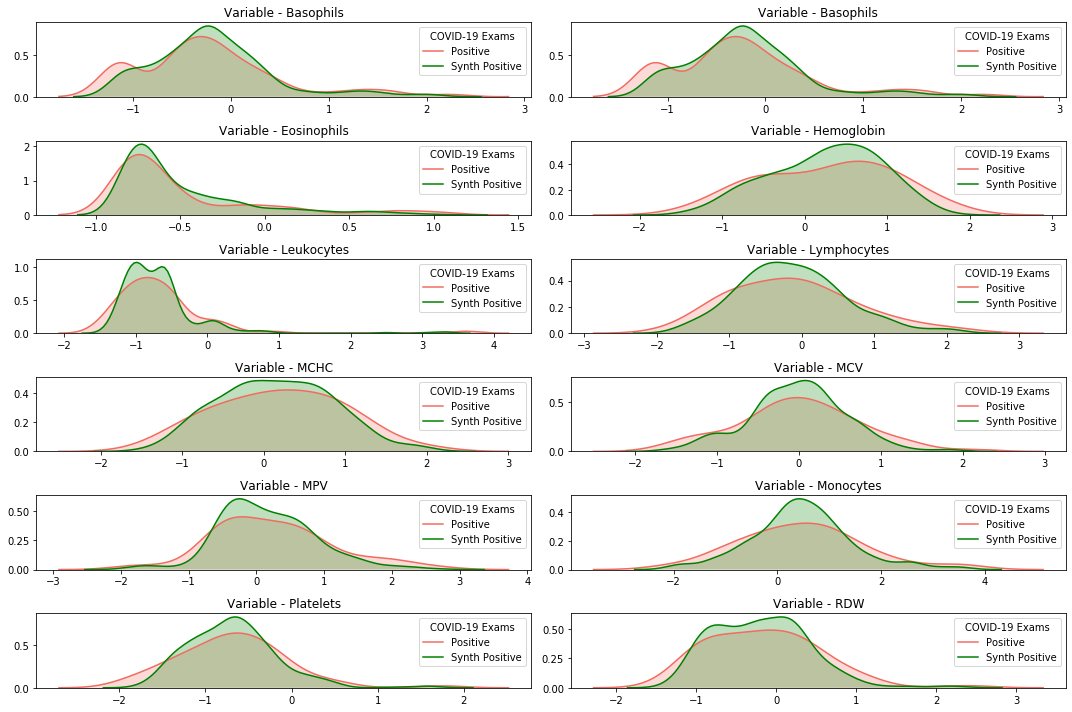

In [11]:
# PLOT - KDE Dist plots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15,10))
r = 0      # Index row
c = 0      # Index col

num_features = ['Basophils', 'Basophils', 'Eosinophils','Hemoglobin', 'Leukocytes', 'Lymphocytes','MCHC','MCV','MPV',
                'Monocytes', 'Platelets', 'RDW']

for f in num_features:
    # Plot distribuição
    sns.kdeplot(list(target_1[f]), shade=True, color='#F06C61', ax=axes[r][c], label='Positive')
    sns.kdeplot(list(target_2[f]), shade=True, color='Green', ax=axes[r][c], label='Synth Positive')
    # Plot configs
    axes[r][c].legend(title='COVID-19 Exams', loc='upper right')
    axes[r][c].set_title('Variable - ' + f)
    # Index control
    c += 1
    if c > 1:
        c = 0
        r += 1

plt.tight_layout()

## New correlation heatmap with synth features

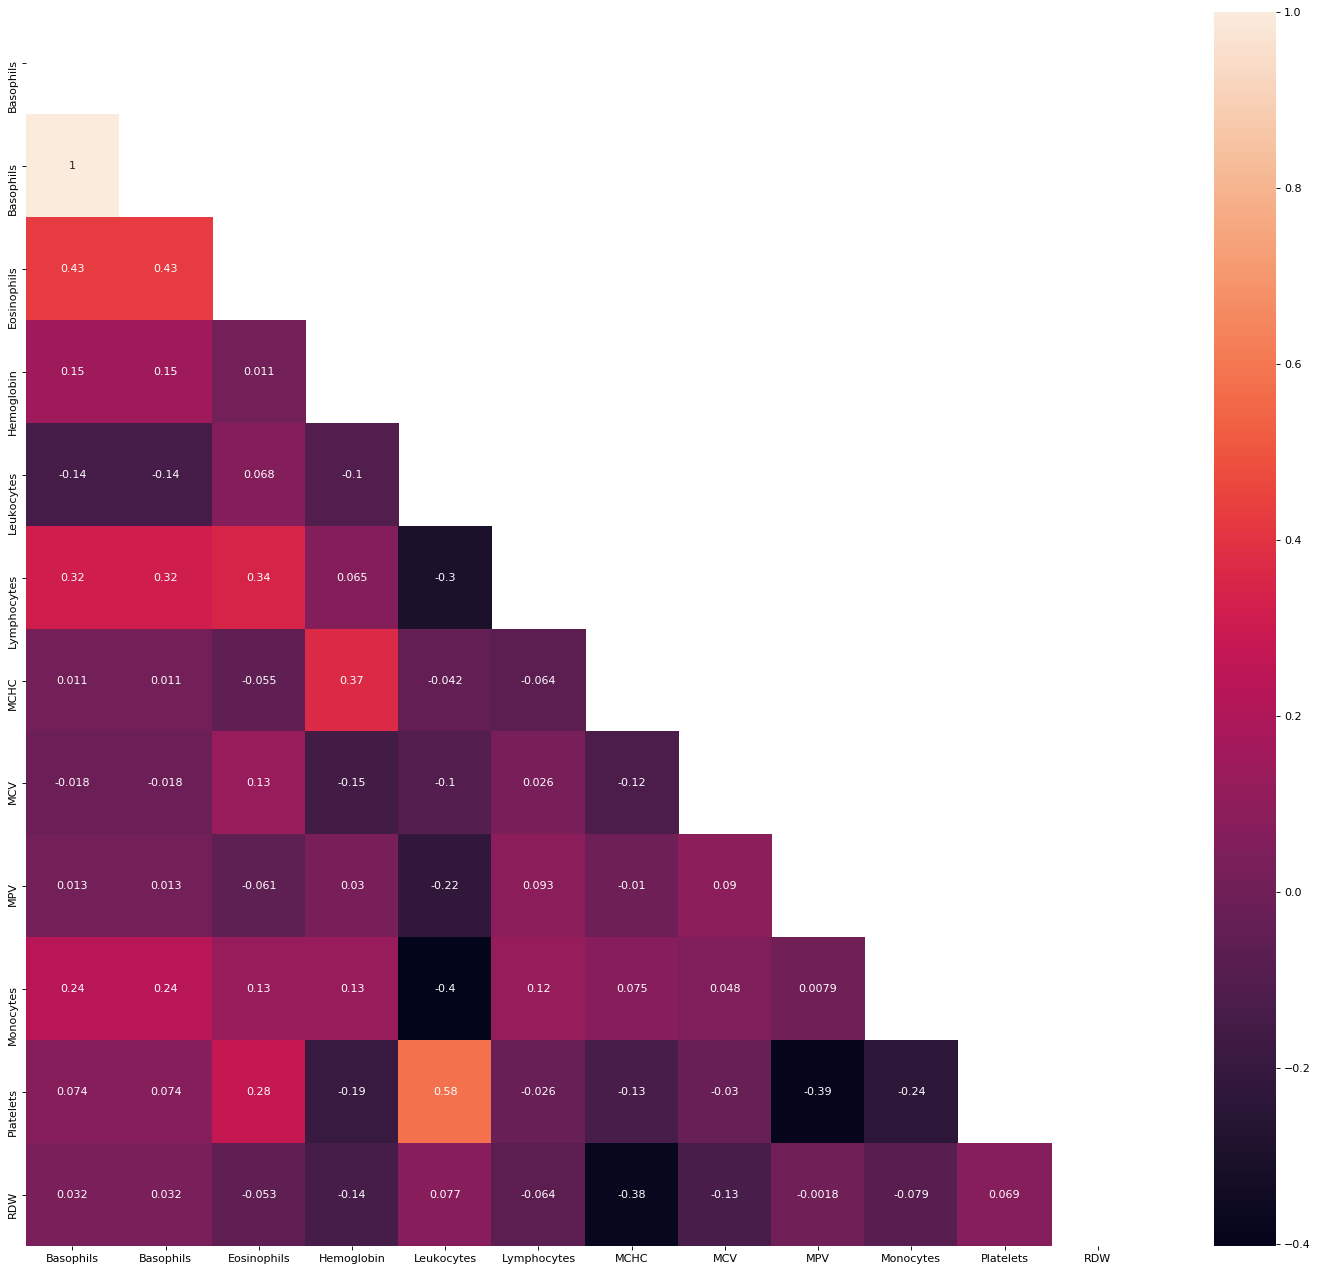

In [12]:
# Correlation calculation
spearman_corr = df_synth[num_features].corr('spearman')
matrix = np.triu(spearman_corr)

# Plot
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(spearman_corr, annot = True, mask=matrix)
plt.tight_layout()

### Commentary
SMOTE increases some correlations, but not high enough ( > 0.8) to give any danger.

In [13]:
sorted(list(pd.unique(x_train_smt['Patient age quantile'])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# Transforming data

Apply `MinMaxScaler` for **Patient age quantile** to reduce the scale difference between this variable and the numerical features

## See expected results

It's known that maximum is 19 and minimum is 0

In [14]:
age_origin = sorted(list(pd.unique(x_train['Patient age quantile'])))
age_transf = sorted(list(pd.unique(x_train['Patient age quantile'])/19))
for origin, transf in zip(age_origin, age_transf):
    print(origin, '->', round(transf,6))

0 -> 0.0
1 -> 0.052632
2 -> 0.105263
3 -> 0.157895
4 -> 0.210526
5 -> 0.263158
6 -> 0.315789
7 -> 0.368421
8 -> 0.421053
9 -> 0.473684
10 -> 0.526316
11 -> 0.578947
12 -> 0.631579
13 -> 0.684211
14 -> 0.736842
15 -> 0.789474
16 -> 0.842105
17 -> 0.894737
18 -> 0.947368
19 -> 1.0


## Apply Transformation

In [15]:
# Define instance and fit in train set
mms = MinMaxScaler().fit(np.array(x_train['Patient age quantile']).reshape(-1, 1))

In [16]:
# Apply transformation x train
x_train['Patient age quantile'] = mms.transform(np.array(x_train['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x test
x_test['Patient age quantile'] = mms.transform(np.array(x_test['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation x train with SMOTE
x_train_smt['Patient age quantile'] = mms.transform(np.array(x_train_smt['Patient age quantile']).reshape(-1, 1)).round(6)
# Apply transformation df
df['Patient age quantile'] = mms.transform(np.array(df['Patient age quantile']).reshape(-1, 1)).round(6)

# Auxiliar Functions

In [17]:
def printModelGeneralInfo(model, hp, score, metric_evaluated):
    print('#####################################################')
    print('Model:', type(model).__name__)
    print('Metric: ', metric_evaluated, ' | Score (%): ', 100*round(score,5))
    print('Best Parameters: ', hp)
    print('#####################################################\n')

In [18]:
def optimizationGridCV(model_estimator, params, metric_to_eval, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Grid Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = GridSearchCV(estimator=model_estimator,param_grid=params,cv=5,scoring=metric_to_eval,verbose=2,n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [19]:
def optimizationRandomCV(model_estimator, params, metric_to_eval, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Random Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in RandomizedSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Random Search CV object
    hp_search = RandomizedSearchCV(estimator=model_estimator,
                                   param_distributions=params, 
                                   n_iter=n_iter,
                                   cv=5,
                                   scoring=metric_to_eval,
                                   verbose=2,
                                   random_state=101,
                                   n_jobs=-1)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [20]:
def optimizationBayesCV(model_estimator, params, metric_to_eval, n_iter, features, target):
    """
    Function to evaluate the best set of HP given a specific metric using Bayes Optimization Search CV.
    
    Arguments:
        model_estimator: Model to be evaluated
        params: hyper parameters grid
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        n_iter: iterations in BayesSearchCV
        features: x train set to be used
        target: y train set to be used
    
    Returns:
        (best_model, best_hiperparameters, best_metric_score)
    """
    # Define Search CV object
    hp_search = BayesSearchCV(estimator=model_estimator,
                              search_spaces=params,
                              n_iter=n_iter,
                              cv=5,
                              scoring=metric_to_eval,
                              verbose=0,
                              random_state=101,
                              n_jobs=5,
                              n_points=5)
    # Search
    hp_search.fit(features, target)
    # Finish
    return (hp_search.best_estimator_, hp_search.best_params_, hp_search.best_score_, hp_search.cv_results_)

In [21]:
def optimizationPipeline(estimator,params,x_train,y_train,metric_eval,opt_option='grid',n_iter=None):
    """
    Function to apply a specific HP optimization and present results.
    Arguments:
        estimator: Model to be evaluated
        params: hyper parameters grid
        x_train: self explanatory
        y_train: self explanatory
        metric_to_eval: metric to be evaluated in the search (model evaluation)
        opt_option: define the methodology to HP Optimization. Can be 'grid','random' or 'bayes'
        n_iter: iterations in RandomSearchCV or BayesOptimization. It's ignored if opt_option is 'grid'.
    Returns:
        dictionary with overall results
    """  
    # 1 - SEARCH
    if opt_option == 'grid':
        best_model,best_params,best_score,cv_results = optimizationGridCV(estimator,params,metric_eval,x_train,y_train)
    elif opt_option == 'random':
        best_model,best_params,best_score,cv_results = optimizationRandomCV(estimator,params,metric_eval,n_iter,x_train,y_train)
    elif opt_option == 'bayes':
        best_model,best_params,best_score,cv_results = optimizationBayesCV(estimator,params,metric_eval,n_iter,x_train,y_train)
    else:
        print('ERROR - Wrong opt_option selected')
        return
    
    # Wait for results
    sleep(1.5)    
    # 2 - Show Model Results
    printModelGeneralInfo(best_model, best_params, best_score, metric_eval)
    # 3 - Returns
    returned_dict = {'best_model':best_model,'best_params':best_params,'best_score':best_score,
                     'cv_res':pd.DataFrame(cv_results),'metric_used':metric_eval}
    return returned_dict

# Hyper parameters optimization

Details:
- **Metrics**: `f1_macro` for balanced data (SMOTE) and `f1_macro` for imbalanced data 
- **Models**: Logistic Regression, SVM, Random Forest, Gradient Boosting and XGBoost
- **Process to optimize**: CV 5-Fold Strafied. `grid` is applied for Logistic Regression and SVM (small parameters grid) and `bayes` for the rest.

In [22]:
# Metrics used
metric_oversample = 'f1_macro'
metric_imbalanced = 'f1_macro'

## ----------------------------------------------- Oversampled Data -----------------------------------------------

### Logistic Regression

In [23]:
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
lre_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_oversample,opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  f1_macro  | Score (%):  82.647
Best Parameters:  OrderedDict([('C', 0.021261125350909994), ('class_weight', 'balanced'), ('l1_ratio', 0.15495911410132415)])
#####################################################



### SVM

In [24]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}

## HP Optimization
svm_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_oversample,opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  f1_macro  | Score (%):  94.404
Best Parameters:  OrderedDict([('C', 9.189666056005462), ('class_weight', None), ('gamma', 'scale'), ('kernel', 'rbf'), ('shrinking', False)])
#####################################################



### Random Forest

In [25]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_oversample,opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  f1_macro  | Score (%):  94.415
Best Parameters:  OrderedDict([('class_weight', 'balanced_subsample'), ('max_depth', 29), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
#####################################################



### Gradient Boosting

In [26]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_oversample,opt_option='bayes',n_iter=100)

#####################################################
Model: GradientBoostingClassifier
Metric:  f1_macro  | Score (%):  96.467
Best Parameters:  OrderedDict([('learning_rate', 0.10347028061905007), ('max_depth', 26), ('max_features', 'log2'), ('min_samples_leaf', 6), ('min_samples_split', 8), ('n_estimators', 689), ('subsample', 0.7777567600481455)])
#####################################################



### XGBoost

In [29]:
## Define Estimator
estimator = XGBClassifier(objective='binary:logistic',random_state=1206,booster='gbtree')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-4, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_ove = optimizationPipeline(estimator,params,x_train_smt,y_train_smt,metric_oversample,opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  f1_macro  | Score (%):  93.73
Best Parameters:  OrderedDict([('colsample_bytree', 0.7849455777747363), ('gamma', 0.00481774607596991), ('learning_rate', 0.09884402439416878), ('max_depth', 32), ('min_child_weight', 1), ('n_estimators', 821), ('reg_alpha', 0.004579336760940707), ('reg_lambda', 10.0), ('scale_pos_weight', 0.75), ('subsample', 0.8890217085366714)])
#####################################################



## ----------------------------------------------- Imbalanced Data -----------------------------------------------

### Logistic Regression

In [30]:
# Elastic Net
## Define Estimator
estimator = LogisticRegression(random_state=1206,penalty='elasticnet', solver='saga', max_iter=5000)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'l1_ratio': Real(0, 1, prior='uniform'),
          'class_weight':Categorical(['balanced',None], transform='onehot')}
## HP Optimization
lre_res_imb = optimizationPipeline(estimator,params,x_train,y_train,metric_imbalanced,opt_option='bayes',n_iter=100)

#####################################################
Model: LogisticRegression
Metric:  f1_macro  | Score (%):  67.93400000000001
Best Parameters:  OrderedDict([('C', 0.8298062442503721), ('class_weight', 'balanced'), ('l1_ratio', 0.0)])
#####################################################



### SVM

In [32]:
## Define Estimator
estimator = SVC(random_state=1206, probability=True)
## Define Parameters
params = {'C': Real(1e-4, 10, prior='log-uniform'),
          'shrinking': Categorical([True, False], transform='onehot'),
          'kernel': Categorical(['linear','rbf','poly','sigmoid'], transform='onehot'),
          'gamma': Categorical(['scale', 'auto'], transform='onehot'),
          'class_weight': Categorical(['balanced',None], transform='onehot')}
## HP Optimization
svm_res_imb = optimizationPipeline(estimator,params,x_train,y_train,metric_imbalanced,opt_option='bayes',n_iter=100)

#####################################################
Model: SVC
Metric:  f1_macro  | Score (%):  72.012
Best Parameters:  OrderedDict([('C', 0.9638425172168388), ('class_weight', 'balanced'), ('gamma', 'scale'), ('kernel', 'rbf'), ('shrinking', False)])
#####################################################



### Random Forest

In [33]:
## Define Estimator
estimator = RandomForestClassifier(random_state=1206, criterion='gini', warm_start=True)
## Define Parameters Grid
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'class_weight': Categorical(['balanced','balanced_subsample',None], transform='onehot'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
rfc_res_imb = optimizationPipeline(estimator,params,x_train,y_train,metric_imbalanced,opt_option='bayes',n_iter=100)

#####################################################
Model: RandomForestClassifier
Metric:  f1_macro  | Score (%):  76.05
Best Parameters:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 12), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 15), ('n_estimators', 1000)])
#####################################################



### Gradient Boosting

In [34]:
## Define Estimator
estimator = GradientBoostingClassifier(random_state=1206, loss='deviance', criterion='friedman_mse', warm_start=True)
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_samples_leaf': Integer(1, 8, prior='uniform'),
          'min_samples_split': Integer(2, 16, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-5, 10, prior='log-uniform'),
          'max_features': Categorical(['sqrt','log2'], transform='onehot')}
## HP Optimization
bst_res_imb = optimizationPipeline(estimator,params,x_train,y_train,metric_imbalanced,opt_option='bayes',n_iter=100)

#####################################################
Model: GradientBoostingClassifier
Metric:  f1_macro  | Score (%):  70.421
Best Parameters:  OrderedDict([('learning_rate', 0.01534314770934575), ('max_depth', 32), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 16), ('n_estimators', 577), ('subsample', 1.0)])
#####################################################



### XGBoost

In [35]:
## Define Estimator
estimator = XGBClassifier(objective='binary:logistic',random_state=1206,booster='gbtree')
## Define Parameters
params = {'n_estimators': Integer(100, 1000, prior='uniform'),
          'min_child_weight': Integer(1, 10, prior='uniform'),
          'max_depth': Integer(2, 32, prior='uniform'),
          'subsample': Real(0.75, 1, prior='uniform'),
          'colsample_bytree': Real(0.75, 1, prior='uniform'),
          'scale_pos_weight': Real(0.75, 1, prior='uniform'),
          'learning_rate': Real(1e-6, 10, prior='log-uniform'),
          'gamma': Real(1e-3, 10, prior='log-uniform'),
          'reg_alpha': Real(1e-3, 10, prior='log-uniform'),
          'reg_lambda': Real(1e-3, 10, prior='log-uniform')}
## HP Optimization
xgb_res_imb = optimizationPipeline(estimator,params,x_train,y_train,metric_imbalanced,opt_option='bayes',n_iter=100)

#####################################################
Model: XGBClassifier
Metric:  f1_macro  | Score (%):  69.313
Best Parameters:  OrderedDict([('colsample_bytree', 0.7516221950249294), ('gamma', 3.0215225183662864), ('learning_rate', 0.8765338048577465), ('max_depth', 8), ('min_child_weight', 5), ('n_estimators', 867), ('reg_alpha', 0.5790240229310882), ('reg_lambda', 0.030668150341600715), ('scale_pos_weight', 0.8253286461506423), ('subsample', 0.880256898848867)])
#####################################################



# Baseline Classifiers

## ----------------------------------------------- Imbalanced Data -----------------------------------------------

### Most Frequent

In [36]:
# Create
model_dummy_mf_imb = DummyClassifier(strategy="most_frequent")
# Fit
model_dummy_mf_imb.fit(x_train, y_train)

DummyClassifier(strategy='most_frequent')

### Stratified

In [37]:
# Create
model_dummy_st_imb = DummyClassifier(strategy="stratified")
# Fit
model_dummy_st_imb.fit(x_train,y_train)

DummyClassifier(strategy='stratified')

## ----------------------------------------------- Oversampled Data -----------------------------------------------

### Most Frequent

In [38]:
# Create
model_dummy_mf_ove = DummyClassifier(strategy="most_frequent")
# Fit
model_dummy_mf_ove.fit(x_train_smt,y_train_smt)

DummyClassifier(strategy='most_frequent')

### Stratified

In [39]:
# Create
model_dummy_st_ove = DummyClassifier(strategy="stratified")
# Fit
model_dummy_st_ove.fit(x_train_smt,y_train_smt)

DummyClassifier(strategy='stratified')

# Backtest - Generate dataset
Samples from test set where **COVID is negative** and **Any respiratory disease is positive**

## Functions

In [40]:
def getMatchIdx(idx1, idx2):
    return list(set(idx1) & set(idx2))

def backtestReport(backtestIdx, label, trainIdx, testIdx):
    print('###################',label)
    print('All Match Condition  -',len(backtestIdx),'samples.')
    print('Train Match Conditon -',len(getMatchIdx(trainIdx, backtestIdx)),'samples.')
    print('Test Match Conditon  -',len(getMatchIdx(testIdx, backtestIdx)),'samples.')

## Get all samples

In [41]:
x_resp=df[(df['COVID-19 Exam result'] == 0)&(df['Respiratory Disease detection'] == 1)][features]

## Get a report about how those samples are distributed

In [42]:
backtestReport(x_resp.index, 'Any Respiratory disease', x_train.index, x_test.index)

################### Any Respiratory disease
All Match Condition  - 172 samples.
Train Match Conditon - 146 samples.
Test Match Conditon  - 26 samples.


## Get backtest samples only present in test set

In [43]:
x_resp = x_resp.loc[getMatchIdx(x_test.index, x_resp.index), :]

In [44]:
# Validate
len(x_resp)

26

# Export results

## Function to export best models

In [45]:
def exportModels(best_models_names, best_models_objects,type_of_dataset):
    for model_name, model_object in zip(best_models_names, best_models_objects):
        joblib.dump(model_object, 'results_modelsDevelopment/'+model_name+'_'+type_of_dataset+'.sav')

In [46]:
# Name of the models
models_name_list = ['lre','svm','rfc','bst','xgb','dummy_mf','dummy_st']

## Saving Datasets...

In [54]:
# XY trainset
x_train.to_csv('results_modelsDevelopment/x_train.csv',index=False)
y_train.to_csv('results_modelsDevelopment/y_train.csv',index=False)
# XY trainset with SMOTE
x_train_smt.to_csv('results_modelsDevelopment/x_train_SMOTE.csv',index=False)
y_train_smt.to_csv('results_modelsDevelopment/y_train_SMOTE.csv',index=False)
# XY testset
x_test.to_csv('results_modelsDevelopment/x_test.csv',index=False)
y_test.to_csv('results_modelsDevelopment/y_test.csv',index=False)
# Backtest datasets - Only X because Y is a zero array
x_resp.to_csv('results_modelsDevelopment/x_resp_transformed.csv',index=False)
# Dataset with age transformation
df.to_csv('results_modelsDevelopment/paper_dataset_age_transformed.csv',index=False)

## Saving models

### Oversampled

In [48]:
# Define objects
models_objects_list = [lre_res_ove['best_model'],svm_res_ove['best_model'],rfc_res_ove['best_model'],bst_res_ove['best_model'],
                       xgb_res_ove['best_model'],model_dummy_mf_ove,model_dummy_st_ove]
# Use the function
exportModels(models_name_list, models_objects_list,'oversampled')

## Imbalanced

In [49]:
# Define objects
models_objects_list = [lre_res_imb['best_model'],svm_res_imb['best_model'],rfc_res_imb['best_model'],bst_res_imb['best_model'],
                       xgb_res_imb['best_model'],model_dummy_mf_imb,model_dummy_st_imb]
# Use the function
exportModels(models_name_list, models_objects_list,'imbalanced')